# Integrating single cell gene expression datasets

This notebook contains code snippets, exercises, and questions to walk through methods that integrate multiple single cell datasets from different contexts/experiments/timespoints. We specifically focus on the dimension reduction step to project the cells into a common, lower-dimensional space, and the graph contruction step using the latent features recovered from dimension reduction. We compare different approaches taken by the Conos pipeline (Barkas et al. 2019) and the LIGER pipeline (Welch et al. 2019). The datasets we use come from a pluripotency engineering process, where Tran et al. (2019) take a more specialized mouse embryonic fibroblast cell and try to revert to back to its pluripotent stem cell state. There are two different types of 'cocktails' used to induce the pluripotency, and the high-level question of the experiment concerns whether a newly developed cocktail (A2S system) is more efficient than an existing cocktail (FBS). For best flow of content and to minimize out-of-order execution of code, start from the top and run one block after another. Questions and a couple of exercises at the end are highlighed in blue boxes. References can be found at the bottom.

## Download dataset

Downloaded single-cell gene expression datasets from five different timepoints along the pluripotency engineering process (Tran et al. 2019) from GEO accession GSE108222 on Oct. 16, 2019.

- Starting point in pluripotency-inducing process, Mouse Embryonic Fibroblasts (MEFs):
    - GSM3595429_MEF-Day0-Rep1_S1.counts.umiCounts.passingKneeFilter.table.csv
- Pluripotency engineering using Ascorbic acid, 2i, SGC (A2S) system, day 6:
    - GSM3595427_A2S-Day6-Rep1_S1.counts.umiCounts.passingKneeFilter.table.csv
- Pluripotency engineering using A2S system, induced pluripotent stem cells:
    - GSM3595433_A2S-mESCs-Rep1_S1.counts.umiCounts.passingKneeFilter.table.csv
- Pluripotency engineering using Fetal Bovine Serum (FBS), day 6:
    - GSM3595437_FBS-Day6-Rep1_S1.counts.umiCounts.passingKneeFilter.table.csv
- Pluripotency engineering using FBS, induced pluripotent stem cells:
    - GSM3595431_FBS-mESCs-Rep1_S1.counts.umiCounts.passingKneeFilter.table.csv

## Preprocessing

Depth normalization across cells and variance adjustment across genes was done using the Pagoda method (Fan et al. 2016). As the normalization process removes genes with very sparse expression levels, an intersection of remaining genes were taken across the five timepoints/datasets, creating a final gene-by-cell matrix for each timepoint.


<div class="alert alert-block alert-info">
<b> QUESTION </b> What are alternative normalization methods? Hint: what is another method mentioned in the Conos (Barkas et al. 2019) paper? 
</div>

## Dependencies

The following code was implemented and tested with Python 3.6 in an Anaconda environment installed on a Linux (Centos7) server. To run this code independently, you will need the following dependencies installed:

- jupyter
- scikit-learn (will be installed with Jupyter)
- scipy (will be installed with jupyter)
- bignmf
- numpy (will be installed with bignmf)
- pandas (will be installed with bignmf)
- seaborn
- matplotlib (will be installed with seaborn)

Now loading all required modules:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from bignmf.models.jnmf.integrative import IntegrativeJnmf
from bignmf.models.jnmf.standard import StandardJnmf
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.neighbors import kneighbors_graph

## Load dataset

Load gene-by-cell matrices from 5 timepoints into a Pandas dataframe, and create a dictionary with the name of the timepoint as the key:

In [2]:
data_dir="./" #update as necessary
replicates=[
    "MEF-Day0-Rep1",
    "A2S-Day6-Rep1",
    "A2S-mESCs-Rep1",
    "FBS-Day6-Rep1",
    "FBS-mESCs-Rep1"
]

with open(data_dir+"/common_genes.txt") as f:
    common_genes = f.read().splitlines()
    
datasets = {}
for rep in replicates:
    mat = np.loadtxt("{}/{}/varstab_common_gene_count.txt".format(data_dir,rep))
    with open("{}/{}/varstab_barcodes.txt".format(data_dir,rep)) as f:
         barcodes = f.read().splitlines()
    datasets[rep] = pd.DataFrame(data=mat,index=common_genes,columns=barcodes) #rows=genes, cols=cells

Let's visualize the five datasets as heatmaps:

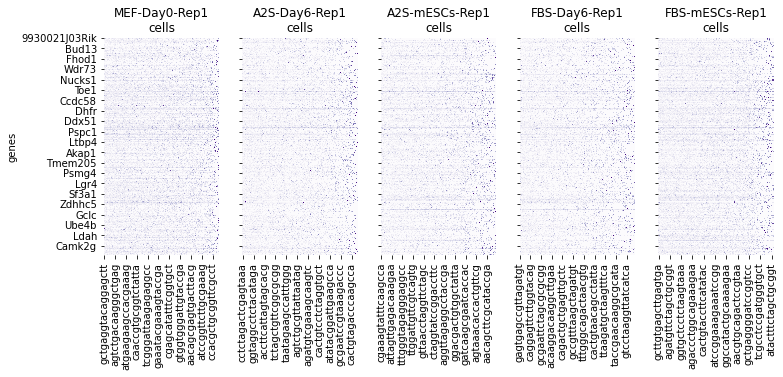

In [3]:
fig = plt.figure(figsize=(12,4))
layout = gridspec.GridSpec(ncols=5, nrows=1, figure=fig)
axes=[]
for i in range(len(replicates)):
    ax = fig.add_subplot(layout[0,i])
    axes.append(ax)

for i in range(len(replicates)):
    ax = axes[i]
    rep = replicates[i]
    dataset = datasets[rep]
    sns.heatmap(ax=ax,data=dataset,cbar=False,cmap="Purples",vmax=10)
    if i > 0:
        ax.set_yticklabels([])
    if i == 0:
        ax.set_ylabel("genes")
    ax.set_title(rep+"\ncells")
    
plt.show()

## Joint NMF (~Conos)

We are going to simulate the way Conos (Barkas et al. 2019) projects cells from multiple contexts/timepoints/experiments into a common space in which a network across all cells can be constructed. One of the ways Conos does this is by using joint NMF (jNMF). Here we use an implementation of jNMF in the bigNMF package.


<div class="alert alert-block alert-info">
<b>QUESTION</b> What other methods does Conos use to project cells into a common, lower-dimensional space?
</div>

In [16]:
k=10
itr=100
trials=1
verbose=True

jnmf_model = StandardJnmf(datasets, k)
jnmf_model.run(trials,itr,verbose=verbose)

		iter: 1 | error: 3.524188
		iter: 2 | error: 3.523486
		iter: 3 | error: 3.522812
		iter: 4 | error: 3.522177
		iter: 5 | error: 3.521562
		iter: 6 | error: 3.520942
		iter: 7 | error: 3.520287
		iter: 8 | error: 3.519555
		iter: 9 | error: 3.518688
		iter: 10 | error: 3.517597
		iter: 11 | error: 3.516159
		iter: 12 | error: 3.514195
		iter: 13 | error: 3.511458
		iter: 14 | error: 3.507637
		iter: 15 | error: 3.502389
		iter: 16 | error: 3.495443
		iter: 17 | error: 3.486780
		iter: 18 | error: 3.476801
		iter: 19 | error: 3.466271
		iter: 20 | error: 3.456041
		iter: 21 | error: 3.446710
		iter: 22 | error: 3.438552
		iter: 23 | error: 3.431571
		iter: 24 | error: 3.425613
		iter: 25 | error: 3.420466
		iter: 26 | error: 3.415927
		iter: 27 | error: 3.411820
		iter: 28 | error: 3.408007
		iter: 29 | error: 3.404380
		iter: 30 | error: 3.400862
		iter: 31 | error: 3.397411
		iter: 32 | error: 3.394003
		iter: 33 | error: 3.390633
		iter: 34 | error: 3.387305
		iter: 35 | error: 3.3

We now visualize the output of jNMF. Note that the gene-by-cell matrix has been transposed, along with the corresponding output factors of jNMF, for ease of visualization.

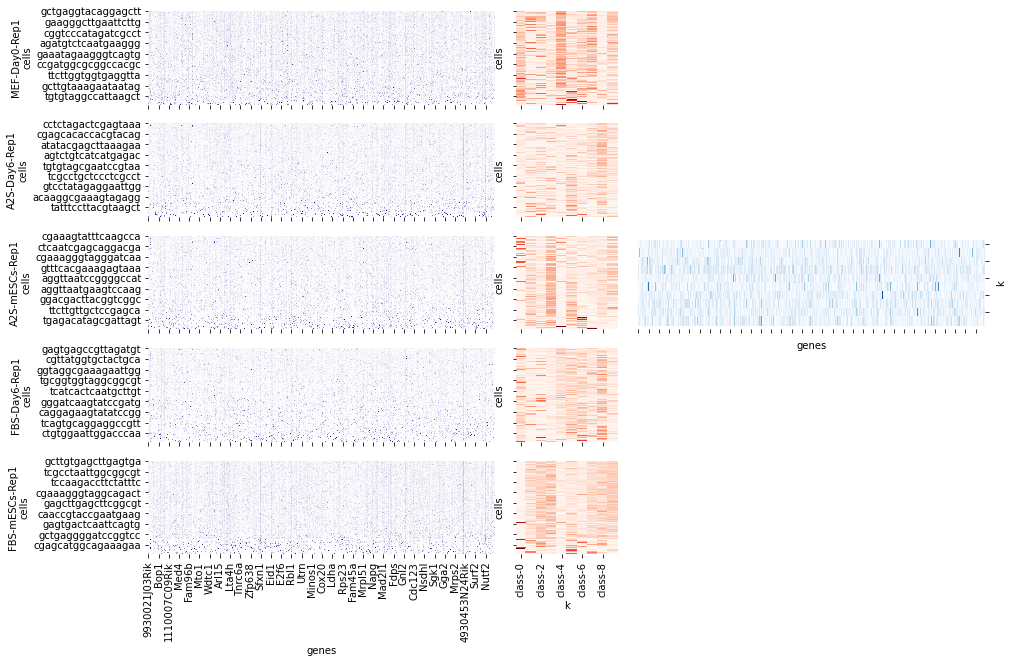

In [5]:
fig = plt.figure(figsize=(15,10))
layout = gridspec.GridSpec(5,7)
axes_x=[]
axes_h=[]
for i in range(len(replicates)):
    ax = fig.add_subplot(layout[i,:3])
    axes_x.append(ax)
    ax = fig.add_subplot(layout[i,3])
    axes_h.append(ax)
ax_w = fig.add_subplot(layout[2,4:])

for i in range(len(replicates)):
    ax_x = axes_x[i]
    ax_h = axes_h[i]
    rep = replicates[i]
    dataset = datasets[rep]
    sns.heatmap(ax=ax_x,data=dataset.T,cbar=False,cmap="Purples",vmax=10)
    ax_x.set_ylabel(rep + "\ncells")
    sns.heatmap(ax=ax_h,data=jnmf_model.h[rep].T,cmap="Reds",cbar=False)
    ax_h.set_ylabel("cells")
    ax_h.set_yticklabels([])
    if i < (len(replicates)-1):
        ax_x.set_xticklabels([])
        ax_h.set_xticklabels([])
    else:
        ax_x.set_xlabel("genes")
        ax_h.set_xlabel("k")
    
    
sns.heatmap(ax=ax_w,data=jnmf_model.w.T,cmap="Blues",cbar=False)
ax_w.set_ylabel("k")
ax_w.set_yticklabels([])
ax_w.yaxis.set_label_position("right")
ax_w.yaxis.tick_right()
ax_w.set_xlabel("genes")
ax_w.set_xticklabels([])
ax_w.set_ylim(k+0.5,-0.5)
plt.show()

<div class="alert alert-block alert-info">
<b>QUESTION</b> Given $X_i \in \mathbb{R}^{n_i \times m}, i \in \{1,2,3,4,5\}$, where $n_i = $ number of cells in each context/experiment/timepoint $i$, and $m = $ number of genes, the objective of jNMF is:

$$
\min \sum_i \|X_i - U_i W \|_F^2
$$

where $U_i \in \mathbb{R}^{n_i \times k}$, $W \in \mathbb{R}^{k \times m}$, where $k =$ reduced dimension of the common space. In the plot above, which heatmaps correspond to which $X_i, U_i, W$?
</div>

## Integrative NMF (~LIGER)

LIGER (Welch et al. 2019) uses integrative NMF (iNMF) instead of jNMF to project cells into a common space. Here we simulate the iNMF step in LIGER using the iNMF implementation in bigNMF module.

In [17]:
k=10
itr=100
trials=1
lamb=0.1
verbose=True

inmf_model = IntegrativeJnmf(datasets, k, lamb)
inmf_model.run(trials,itr,verbose=verbose)

		iter: 1 | error: 3.771608
		iter: 2 | error: 3.780823
		iter: 3 | error: 3.729272
		iter: 4 | error: 3.719031
		iter: 5 | error: 3.642217
		iter: 6 | error: 3.630217
		iter: 7 | error: 3.553116
		iter: 8 | error: 3.542824
		iter: 9 | error: 3.487666
		iter: 10 | error: 3.477612
		iter: 11 | error: 3.441343
		iter: 12 | error: 3.431254
		iter: 13 | error: 3.406536
		iter: 14 | error: 3.396945
		iter: 15 | error: 3.379234
		iter: 16 | error: 3.370290
		iter: 17 | error: 3.356949
		iter: 18 | error: 3.348486
		iter: 19 | error: 3.337828
		iter: 20 | error: 3.329485
		iter: 21 | error: 3.320303
		iter: 22 | error: 3.311677
		iter: 23 | error: 3.303170
		iter: 24 | error: 3.294076
		iter: 25 | error: 3.285961
		iter: 26 | error: 3.276643
		iter: 27 | error: 3.269171
		iter: 28 | error: 3.260156
		iter: 29 | error: 3.253642
		iter: 30 | error: 3.245294
		iter: 31 | error: 3.239800
		iter: 32 | error: 3.232181
		iter: 33 | error: 3.227571
		iter: 34 | error: 3.220592
		iter: 35 | error: 3.2

We now visualize the output of iNMF. Note that again, the gene-by-cell matrix has been transposed, along with the corresponding output factors of iNMF, for ease of visualization.

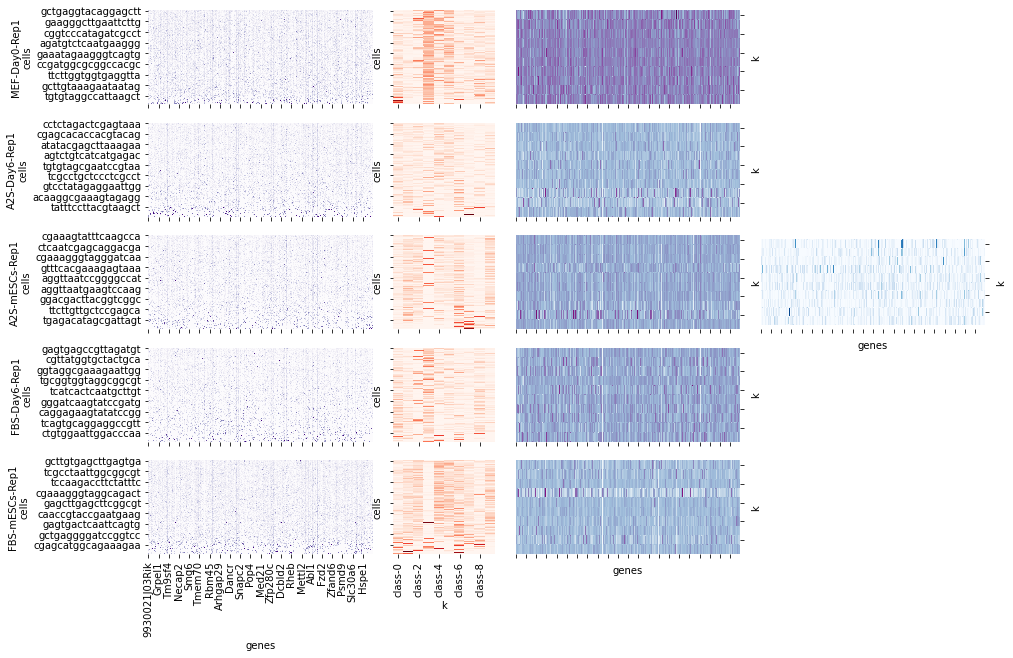

In [18]:
fig = plt.figure(figsize=(15,10))
layout = gridspec.GridSpec(5,7)
axes_x=[]
axes_h=[]
axes_v=[]
for i in range(len(replicates)):
    ax = fig.add_subplot(layout[i,:2])
    axes_x.append(ax)
    ax = fig.add_subplot(layout[i,2])
    axes_h.append(ax)
    ax = fig.add_subplot(layout[i,3:5])
    axes_v.append(ax)
ax_w = fig.add_subplot(layout[2,5:])

for i in range(len(replicates)):
    ax_x = axes_x[i]
    ax_h = axes_h[i]
    ax_v = axes_v[i]
    rep = replicates[i]
    dataset = datasets[rep]
    sns.heatmap(ax=ax_x,data=dataset.T,cbar=False,cmap="Purples",vmax=10)
    ax_x.set_ylabel(rep + "\ncells")
    sns.heatmap(ax=ax_h,data=inmf_model.h[rep].T,cmap="Reds",cbar=False)
    ax_h.set_ylabel("cells")
    ax_h.set_yticklabels([])
    sns.heatmap(ax=ax_v,data=inmf_model.v[rep].T,cmap="BuPu",cbar=False)
    ax_v.set_xticklabels([])
    ax_v.set_ylabel("k")
    ax_v.set_yticklabels([])
    ax_v.yaxis.set_label_position("right")
    ax_v.yaxis.tick_right()
    if i < (len(replicates)-1):
        ax_x.set_xticklabels([])
        ax_h.set_xticklabels([])
    else:
        ax_x.set_xlabel("genes")
        ax_h.set_xlabel("k")
        ax_v.set_xlabel("genes")
    
sns.heatmap(ax=ax_w,data=inmf_model.w.T,cmap="Blues",cbar=False)
ax_w.set_ylabel("k")
ax_w.set_yticklabels([])
ax_w.yaxis.set_label_position("right")
ax_w.yaxis.tick_right()
ax_w.set_xlabel("genes")
ax_w.set_xticklabels([])
ax_w.set_ylim(k+0.5,-0.5)
plt.show()

<div class="alert alert-block alert-info">
<b>QUESTION</b> Given $X_i \in \mathbb{R}^{n_i \times m}, i \in \{1,2,3,4,5\}$, where $n_i = $ number of cells in each context/experiment/timepoint $i$, and $m = $ number of genes, the objective of iNMF is:

$$
\min \sum_i \|X_i - U_i (V_i + W) \|_F^2
$$

where $U_i \in \mathbb{R}^{n_i \times k}$, $V_i \in \mathbb{R}^{k \times m}$, and $W \in \mathbb{R}^{k \times m}$, where $k =$ reduced dimension of the common space. In the plot above, which heatmaps correspond to which $X_i, U_i, V_i, W$? How would you interpret the factors $V_i$ and $W$? What potential benefit do you see in iNMF vs jNMF?
</div>

## Cell graph construction with jNMF factors (~Conos)

Now we construct a graph connecting cells across timepoints using their proximity in the common $k$-dimensional space from jNMF, where we had set $k=10$. We are going to use a simplified version of how Conos constructs this graph:

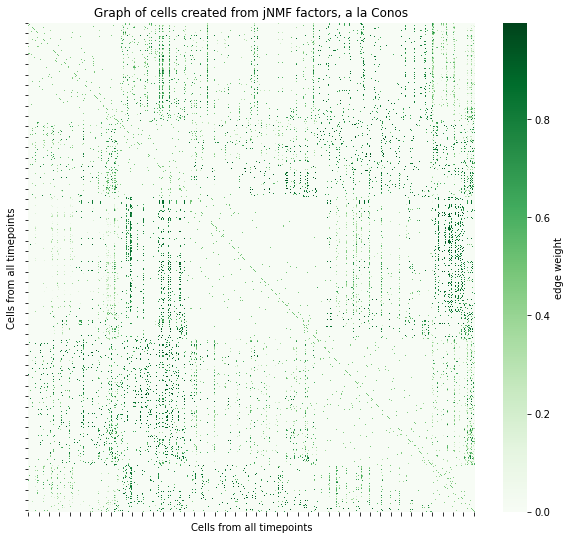

In [19]:
jnmf_cell_latent_features ={}
        
#Row-normalize
for rep in replicates:
    cell_latent_features = jnmf_model.h[rep].T.values #cell-by-latent features/loadings matrix
    jnmf_cell_latent_features[rep] = normalize(cell_latent_features, axis=1, norm='l1')

c = 0.5
for rep1 in replicates:
    cells1 = jnmf_cell_latent_features[rep1]
    for rep2 in replicates:
        cells2 = jnmf_cell_latent_features[rep2]
        dist = cdist(cells1,cells2,metric="correlation")
        dist = 1 - dist #now proximity instead of distance
        dist[dist<0] = 0
        if rep1==rep2:
            k = 5
            dist = dist*c #shrinking the influence of neighbors from same timepoint
        else:
            k = 15
        n,m = dist.shape
        idx = np.argpartition(dist,m-k,axis=1)[:,:-1*k] #index of furthest m-k neighbors for each data point
        dist[np.arange(n)[:,None],idx] = 0 #set everything to 0 except the closest k neighbors
        if rep2 == replicates[0]:
            rep1_graph = dist
        else:
            rep1_graph = np.concatenate((rep1_graph,dist),axis=1)
    if rep1 == replicates[0]:
        G_j = rep1_graph
    else:
        G_j = np.concatenate((G_j,rep1_graph),axis=0)

plt.figure(figsize=(10,9))
ax = sns.heatmap(G_j,cmap='Greens',cbar_kws={'label': 'edge weight'})
ax.set_xticklabels([])
ax.set_xlabel('Cells from all timepoints')
ax.set_yticklabels([])
ax.set_ylabel('Cells from all timepoints')
ax.set_title('Graph of cells created from jNMF factors, a la Conos')
plt.show()

<div class="alert alert-block alert-info">

<b>EXERCISE</b> Even if you are not as familiar with Python, see if you can match the key steps in 'Pairwise dataset alignment (phase II)' and 'Joint graph (phase III)' sections under Methods to chunks of code above. What differences do you notice in our implementation/version above?
</div>

<div class="alert alert-block alert-info">
<b>QUESTION</b> 
This graph is not symmetric. What graph construction method would create a symmetric neighborhood graph? Hint: what is mentioned as the default inter-edge construction method in the 'Joint graph (phase III)' section under Methods?

</div>

## Cell graph construction with iNMF factors (~LIGER)

This time we construct a graph connecting cells across timepoints using their proximity in the common $k$-dimensional space from iNMF, where $k=10$. We are going to use a simplified version of how LIGER constructs this graph:

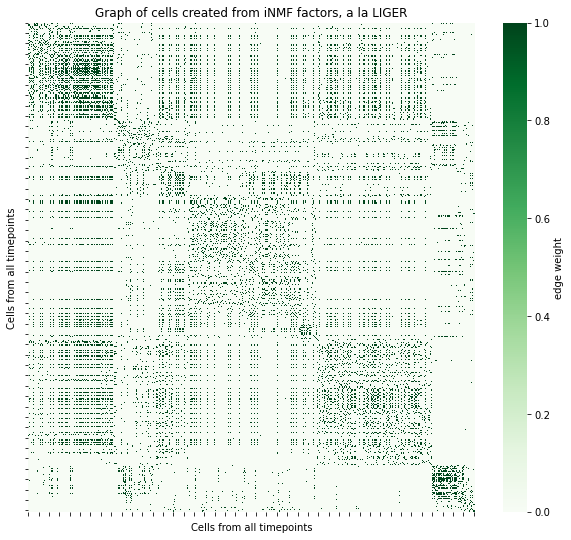

In [20]:
inmf_cell_latent_features = {}
        
#Row-normalize
for rep in replicates:
    cell_latent_features = inmf_model.h[rep].T.values #cell-by-latent features/loadings matrix
    inmf_cell_latent_features[rep] = normalize(cell_latent_features, axis=1, norm='l2')

k = 30
for rep in replicates:
    H = inmf_cell_latent_features[rep]
    n,m = H.shape
    knn = kneighbors_graph(H,k).toarray() #by default uses Euclidean distance
    F = np.zeros((n,m))
    idx = np.argmax(H, axis=1) #index of highest loading for each cell/row
    F[np.arange(n),idx] = 1
    FN = np.zeros((n,m))
    for i in range(n):
        knn_mask = (knn[i,:]>0)
        FN[i,:] = np.sum(F[knn_mask,:],axis=0)
    if rep == replicates[0]:
        factor_neighborhood = FN
    else:
        factor_neighborhood = np.concatenate((factor_neighborhood,FN),axis=0)
        
G_i = squareform(pdist(factor_neighborhood,metric='cityblock')) #a.k.a. Manhattan distance
cutoff=20
A_i = (G_i < cutoff) #if distance is less than some cutoff, connect nodes

plt.figure(figsize=(10,9))
ax = sns.heatmap(A_i,cmap='Greens',cbar_kws={'label': 'edge weight'})
ax.set_xticklabels([])
ax.set_xlabel('Cells from all timepoints')
ax.set_yticklabels([])
ax.set_ylabel('Cells from all timepoints')
ax.set_title('Graph of cells created from iNMF factors, a la LIGER')
plt.show()  

<div class="alert alert-block alert-info">
<b>EXERCISE</b> Even if you are not as familiar with Python, see if you can match the key steps in 'Joint clustering and factor normalization' section under Methods to chunks of code above. Any differences you notice in our implementation? What assumptions were made in our implementation?
</div>

## Spectral clustering on graph from jNMF cell factors

The central biological question we set out to answer was: is A2S system more efficient than FBS in inducing pluripotency? After 6 days of applying A2S and FBS, if A2S is more efficient, we expect the cells under the A2S system to be closer to the final pluripotent cell state. We'll see if we can discern this pattern with spectral clustering.

In [21]:
def spectralClustering_step1(affinity_graph):
    A = affinity_graph
    row_sum = A.sum(axis=1)
    D = np.diag(row_sum)
    L = D-A
    evals, evecs = np.linalg.eig(L)
    #numpy tacks on complex parts, discard them
    evals = evals.real 
    evecs = evecs.real
    #sort eigen values and corresponding eigen vectors
    evals = evals[np.argsort(evals)]
    evecs = evecs[:,np.argsort(evals)]
    return evals,evecs

In [22]:
A_j = G_j
evals_j, evecs_j = spectralClustering_step1(A_j)
evals_i, evecs_i = spectralClustering_step1(A_i)

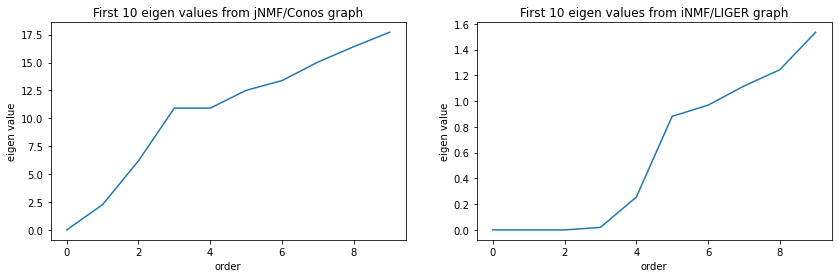

In [23]:
fig = plt.figure(figsize=(14,4))
gs = gridspec.GridSpec(nrows=1,ncols=2,figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

ax1.plot(evals_j[:10])
ax1.set_title("First 10 eigen values from jNMF/Conos graph")
ax1.set_xlabel("order")
ax1.set_ylabel("eigen value")
ax2.plot(evals_i[:10])
ax2.set_title("First 10 eigen values from iNMF/LIGER graph")
ax2.set_xlabel("order")
ax2.set_ylabel("eigen value")
plt.show()

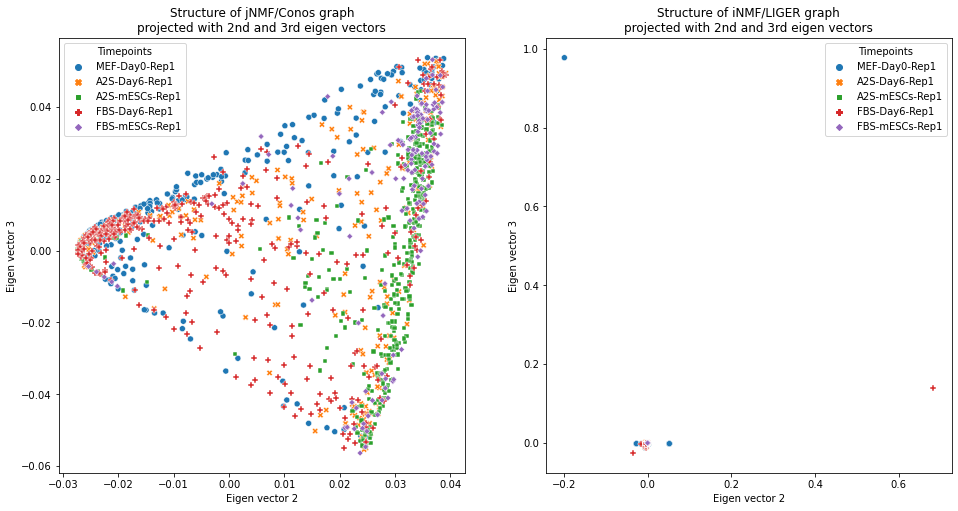

In [29]:
timepoints = []
for rep in replicates:
    n = datasets[rep].shape[1]
    timepoints.extend([rep]*n)
    
df_j = pd.DataFrame(data=evecs_j[:,1:3],columns=['Eigen vector 2','Eigen vector 3'])
df_j['Timepoints'] = timepoints

df_i = pd.DataFrame(data=evecs_i[:,1:3],columns=['Eigen vector 2','Eigen vector 3'])
df_i['Timepoints'] = timepoints

fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=1,ncols=2,figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
sns.scatterplot(ax=ax1, data=df_j,x='Eigen vector 2',y='Eigen vector 3',style='Timepoints',hue='Timepoints')
ax1.set_title("Structure of jNMF/Conos graph\nprojected with 2nd and 3rd eigen vectors")
sns.scatterplot(ax=ax2, data=df_i,x='Eigen vector 2',y='Eigen vector 3',style='Timepoints',hue='Timepoints')
ax2.set_title("Structure of iNMF/LIGER graph\nprojected with 2nd and 3rd eigen vectors")
plt.show()

<div class="alert alert-block alert-info">
<b>EXERCISE</b> 
Write Python code or pseudocode to finish spectral clustering, using the eigen vectors yielded above, with $k=2$. If you end up implmenting this in Python: does majority of A2S day-6 cells cluster with mESC cells or with MEF cells? What about F2S day-6 cells? What does this tell us about the efficiency of A2S system compared to FBS?
</div>

<div class="alert alert-block alert-info">
<b>EXERCISE</b> 
Unfortunately spectral clustering sometimes yields results as in iNMF/LIGER graph projection you see above, where a handful of eigen vectors have extreme values for a very small number of data points (try plotting the 3rd eigen vector, or the 4th/5th/6th, to see this more clearly), rendering them useless for the overall clustering effort. Try playing around with the graph construction step, and with different Laplacians, to see if you can remove this problem. If you're more ambitious, check out Zhang & Rohe 2018 (<a href="https://papers.nips.cc/paper/8262-understanding-regularized-spectral-clustering-via-graph-conductance.pdf">https://papers.nips.cc/paper/8262-understanding-regularized-spectral-clustering-via-graph-conductance.pdf</a>) to learn why this might happen, and what they propose to remedy the potential cause.
</div>

<div class="alert alert-block alert-info">
<b>QUESTION</b> 
We applied spectral clustering. Which clustering algorithm(s) did Conos use? What about LIGER?
</div>

## References

Barkas, N., Petukhov, V., Nikolaeva, D., Lozinsky, Y., Demharter, S., Khodosevich, K., Kharchenko, P.V., 2019. Joint analysis of heterogeneous single-cell RNA-seq dataset collections. Nat Methods 16, 695–698. https://doi.org/10.1038/s41592-019-0466-z

Fan, J., Salathia, N., Liu, R., Kaeser, G.E., Yung, Y.C., Herman, J.L., Kaper, F., Fan, J.-B., Zhang, K., Chun, J., Kharchenko, P.V., 2016. Characterizing transcriptional heterogeneity through pathway and gene set overdispersion analysis. Nat Methods 13, 241–244. https://doi.org/10.1038/nmeth.3734

Tran, K.A., Pietrzak, S.J., Zaidan, N.Z., Siahpirani, A.F., McCalla, S.G., Zhou, A.S., Iyer, G., Roy, S., Sridharan, R., 2019. Defining Reprogramming Checkpoints from Single-Cell Analyses of Induced Pluripotency. Cell Reports 27, 1726-1741.e5. https://doi.org/10.1016/j.celrep.2019.04.056

Welch, J.D., Kozareva, V., Ferreira, A., Vanderburg, C., Martin, C., Macosko, E.Z., 2019. Single-Cell Multi-omic Integration Compares and Contrasts Features of Brain Cell Identity. Cell. https://doi.org/10.1016/j.cell.2019.05.006

Zhang, Y., Rohe, K., 2018. Understanding Regularized Spectral Clustering via Graph Conductance, in: Bengio, S., Wallach, H., Larochelle, H., Grauman, K., Cesa-Bianchi, N., Garnett, R. (Eds.), Advances in Neural Information Processing Systems 31. Curran Associates, Inc., pp. 10631–10640.
